# AlexNet Attempt

## Data Loading

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea
import os
from tqdm import tqdm
import cv2 as op
import torch
from torchsummary import summary
import torchmetrics

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [40]:
PATH = 'C:/Users/chand/OneDrive/Desktop/ai/dataset'
label2id = {}
for i, label in enumerate(os.listdir(PATH)):
    label2id[label] = i
    
id2label = {key : value for (value, key) in label2id.items()}

filenames, outcome = [], []

for label in tqdm(os.listdir(PATH)):
    for img in os.listdir(os.path.join(PATH, label)):
        filenames.append(os.path.join(PATH, label, img))
        outcome.append(label)  # Append label (class name) instead of integer ID

df = pd.DataFrame({
    "filename" : filenames,
    "outcome" : outcome  # This will now contain the class names (labels)
})

df = df.sample(frac = 1)
df.head()

100%|██████████| 4/4 [00:00<00:00, 124.58it/s]


,filename,outcome
2858,C:/Users/chand/OneDrive/Desktop/ai/dataset\gla...,glaucoma
1217,C:/Users/chand/OneDrive/Desktop/ai/dataset\dia...,diabetic_retinopathy
4188,C:/Users/chand/OneDrive/Desktop/ai/dataset\nor...,normal
127,C:/Users/chand/OneDrive/Desktop/ai/dataset\cat...,cataract
3487,C:/Users/chand/OneDrive/Desktop/ai/dataset\nor...,normal


C:\Users\chand\AppData\Local\Temp\ipykernel_12308\3895073008.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sea.countplot(x = 'outcome', data = df, palette = 'Blues_d')


<Axes: xlabel='outcome', ylabel='count'>

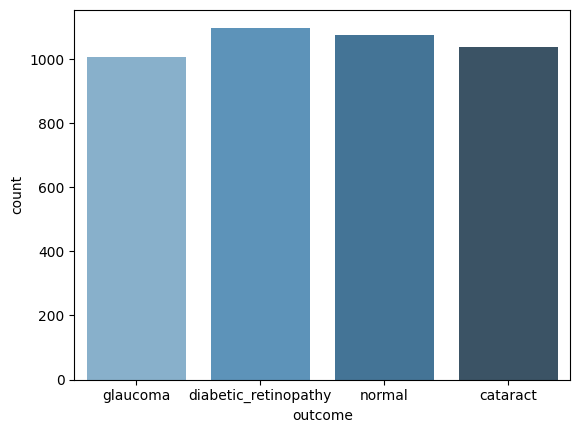

In [41]:
sea.countplot(x = 'outcome', data = df, palette = 'Blues_d')

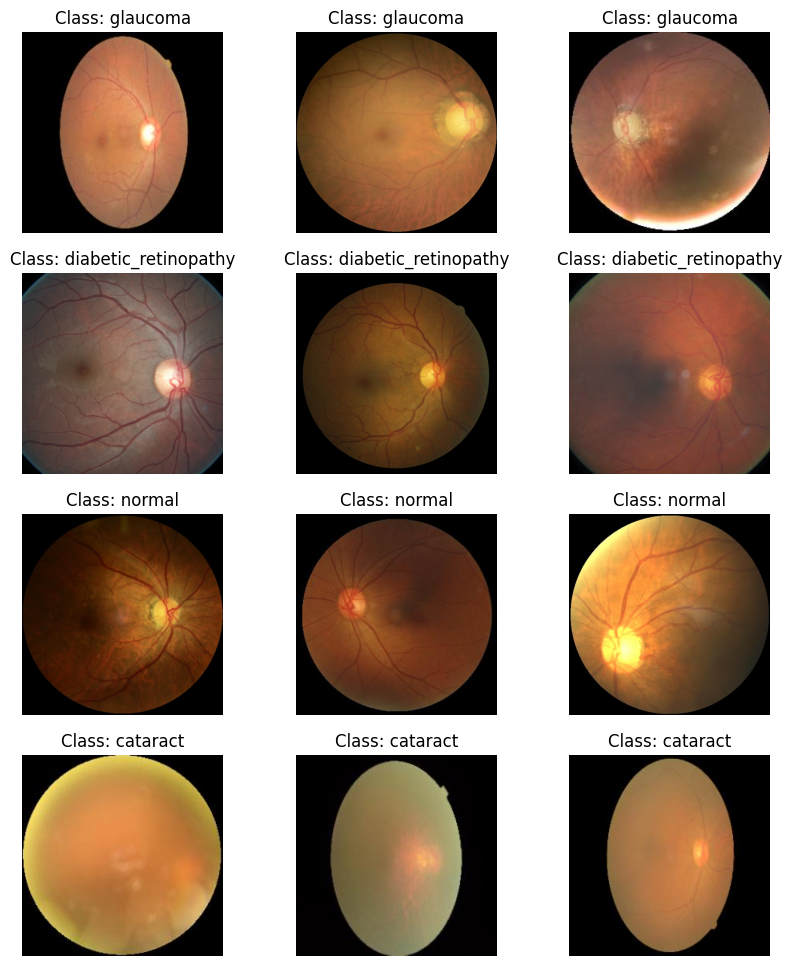

In [42]:
def load_image(path):
    img = plt.imread(path)
    img = (img - img.min()) / img.max()
    return img

# Get unique class names
unique_classes = df['outcome'].unique()

counter = 0

plt.figure(figsize=(10, 12))

# Loop through the unique classes and plot images for each class
for i, class_name in enumerate(unique_classes):
    for path in df[df['outcome'] == class_name].sample(n=3)['filename']:
        plt.subplot(4, 3, counter + 1)
        img = load_image(path)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Class: {class_name}')
        counter += 1

plt.show()

In [43]:
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Updated transformations with 227x227 input size for AlexNet
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=(227, 227)),  # Change size to 227x227 for AlexNet
    transforms.Grayscale(num_output_channels=3),  # Ensure 3-channel input for AlexNet
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for pre-trained AlexNet
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=(227, 227)),  # Change size to 227x227 for AlexNet
    transforms.Grayscale(num_output_channels=3),  # Ensure 3-channel input for AlexNet
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for pre-trained AlexNet
])

class EyeDataset(Dataset):
    def __init__(self, df, n_classes, transform=None):
        self.df = df
        self.n_samples = len(self.df)
        self.n_classes = n_classes
        self.transform = transform
        
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, index):
        img = plt.imread(self.df.iloc[index, 0])  # Read image from file path
        label = self.df.iloc[index, 1]
        
        img = (img - img.min()) / (img.max() - img.min())  # Normalize image between 0 and 1
        
        if self.transform:
            img = self.transform(img)
            
        return img.to(torch.float32), torch.tensor(label, dtype=torch.long)



In [44]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Define the root path of the dataset
root_path = 'C:/Users/chand/OneDrive/Desktop/ai/dataset'
# Define the subdirectories and their labels
subdirectories = ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

# Initialize an empty list to store the data
data = []

# Iterate over each subdirectory and list the files
for subdir in subdirectories:
    subdir_path = os.path.join(root_path, subdir)
    files = os.listdir(subdir_path)
    
    # Append the file paths and labels to the data list
    for file in files:
        file_path = os.path.join(subdir_path, file)
        data.append((file_path, subdir))

# Create a DataFrame from the data list
df = pd.DataFrame(data, columns=['image_path', 'label'])

# Split the DataFrame into training and validation sets
df_train, df_val = train_test_split(df, test_size=0.15, random_state=28)

# Print the shapes of the resulting DataFrames
print(df_train.shape, df_val.shape)

(3584, 2) (633, 2)


In [45]:
NUM_CLASSES = 4
BATCH_SIZE = 128

train_dataset = EyeDataset(df_train, NUM_CLASSES, train_transform)
val_dataset = EyeDataset(df_val, NUM_CLASSES, val_transform)

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False)

In [46]:
import torch
import torch.nn as nn
import torchvision
import torchmetrics
from tqdm import tqdm

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.base = torchvision.models.alexnet(pretrained=True)  # Use AlexNet

        # Unfreeze all layers for better learning
        for param in self.base.parameters():
            param.requires_grad = True

        # Define a new classifier with proper weight initialization
        self.block = nn.Sequential(
            nn.Linear(256 * 6 * 6, 128),  # AlexNet's last feature map is 256 channels, 6x6 spatial size
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 4)  # Assuming 4 classes for classification
        )
        
        # Initialize the weights of the linear layers
        nn.init.kaiming_normal_(self.block[0].weight)  # He initialization for the first linear layer
        nn.init.xavier_normal_(self.block[3].weight)  # Xavier initialization for the output layer
        
        # AlexNet's classifier part is normally used, so we override it with our own
        self.base.classifier = nn.Sequential()
        
    def get_optimizer(self):
        # Adjust learning rates and add a scheduler
        optimizer = torch.optim.AdamW([
            {'params': self.base.parameters(), 'lr': 1e-5},  # Lower learning rate for base
            {'params': self.block.parameters(), 'lr': 1e-4}  # Higher learning rate for classifier block
        ])
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Scheduler
        return optimizer, scheduler
    
    def forward(self, x):
        x = self.base.features(x)  # Forward pass through feature extractor
        x = torch.flatten(x, 1)  # Flatten feature map
        x = self.block(x)  # Forward pass through classifier block
        return x

class Trainer(nn.Module):
    def __init__(self, train_loader, val_loader, device, class_weights=None):
        super().__init__()
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        
        self.model = Net().to(self.device)
        self.optimizer, self.scheduler = self.model.get_optimizer()
        
        # Add class weights if necessary (for handling class imbalance)
        self.loss_fxn = nn.CrossEntropyLoss(weight=class_weights)
        
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=4).to(self.device)
        
        self.history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    def training_step(self, x, y):
        pred = self.model(x)
        loss = self.loss_fxn(pred, y)
        acc = self.accuracy(pred, y)
        
        self.optimizer.zero_grad()
        loss.backward()

        # Apply gradient clipping to avoid exploding gradients
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
        
        self.optimizer.step()
        
        return loss, acc
    
    def val_step(self, x, y):
        with torch.no_grad():
            pred = self.model(x)
            loss = self.loss_fxn(pred, y)
            acc = self.accuracy(pred, y)
            
        return loss, acc
    
    def step_fxn(self, loader, step):
        loss, acc = 0, 0
        
        for X, y in tqdm(loader):
            X, y = X.to(self.device), y.to(self.device)
            l, a = step(X, y)
            loss += l.item()
            acc += a.item()
            
        return loss / len(loader), acc / len(loader)
    
    def train(self, epochs):
        for epoch in tqdm(range(epochs)):
            train_loss, train_acc = self.step_fxn(self.train_loader, self.training_step)
            val_loss, val_acc = self.step_fxn(self.val_loader, self.val_step)
            
            # Learning rate scheduler step
            self.scheduler.step()
            
            for item, value in zip(self.history.keys(), [train_loss, val_loss, train_acc, val_acc]):
                self.history[item].append(value)
            
            print("[Epoch: {}] Train: [loss: {:.3f} acc: {:.3f}] Val: [loss: {:.3f} acc: {:.3f}]".format(
                epoch + 1, train_loss, train_acc, val_loss, val_acc))

# If class imbalance exists, pass class weights to Trainer
# Example: class_weights = torch.tensor([1.0, 2.0, 1.0, 1.5]).to(device)  # Customize based on class distribution



In [47]:
trainer = Trainer(train_loader, val_loader, device)

c:\Users\chand\OneDrive\Desktop\ai\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\chand\OneDrive\Desktop\ai\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [48]:
summary(trainer.model.base, (3, 227, 227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 56, 56]          23,296
              ReLU-2           [-1, 64, 56, 56]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

torch.Size([32, 3, 256, 256]) torch.Size([32])


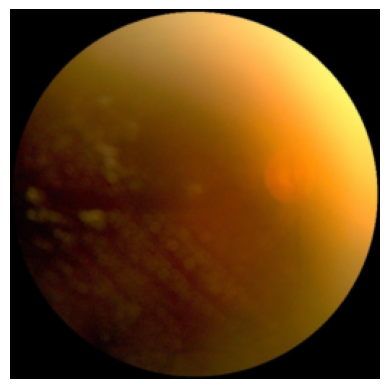

 20%|██        | 1/5 [05:28<21:52, 328.07s/it]

Epoch 1/5, Train Loss: 1.3720, Train Acc: 0.4166, Val Loss: 1.1112, Val Acc: 0.5186


 40%|████      | 2/5 [09:06<13:10, 263.56s/it]

Epoch 2/5, Train Loss: 1.0444, Train Acc: 0.5477, Val Loss: 0.9558, Val Acc: 0.6128


 60%|██████    | 3/5 [12:42<08:03, 241.89s/it]

Epoch 3/5, Train Loss: 1.0199, Train Acc: 0.5617, Val Loss: 0.8476, Val Acc: 0.6567


 80%|████████  | 4/5 [16:23<03:53, 233.66s/it]

Epoch 4/5, Train Loss: 0.8356, Train Acc: 0.6437, Val Loss: 0.9373, Val Acc: 0.6182


100%|██████████| 5/5 [20:02<00:00, 240.41s/it]

Epoch 5/5, Train Loss: 0.8799, Train Acc: 0.6501, Val Loss: 0.8268, Val Acc: 0.6624


In [49]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torchvision import models

# Define the root path of the dataset
root_path = 'C:/Users/chand/OneDrive/Desktop/ai/dataset'

# Define the transforms
transform = transforms.Compose([
    transforms.Resize((256, 256), antialias=True),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create the dataset
dataset = datasets.ImageFolder(root=root_path, transform=transform)

# Split the dataset into training and validation sets
train_size = int(0.85 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create the DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Get a batch of data to verify
a, b = next(iter(train_loader))
print(a.shape, b.shape)

# Display the first image in the batch
img = a[0].permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # De-normalize
img = img.numpy()
plt.imshow(img)
plt.axis('off')
plt.show()

# Clean up
del(a)
del(b)

# Use AlexNet model
class AlexNetModel(nn.Module):
    def __init__(self):
        super(AlexNetModel, self).__init__()
        self.model = models.alexnet(pretrained=True)
        
        # Replace the classifier part of AlexNet to fit your dataset (4 classes)
        self.model.classifier[6] = nn.Linear(4096, 4)
    
    def forward(self, x):
        return self.model(x)

model = AlexNetModel()

class Trainer:
    def __init__(self, model, train_loader, val_loader, device):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(model.parameters(), lr=0.001)
        self.history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    def training_step(self, X, y):
        self.model.train()
        self.optimizer.zero_grad()
        outputs = self.model(X)
        loss = self.criterion(outputs, y)
        loss.backward()
        self.optimizer.step()
        _, preds = torch.max(outputs, 1)
        acc = (preds == y).float().mean()
        return loss.item(), acc.item()

    def val_step(self, X, y):
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X)
            loss = self.criterion(outputs, y)
            _, preds = torch.max(outputs, 1)
            acc = (preds == y).float().mean()
        return loss.item(), acc.item()

    def step_fxn(self, loader, step):
        total_loss, total_acc = 0, 0
        for X, y in tqdm(loader):
            X, y = X.to(self.device), y.to(self.device)
            l, a = step(X, y)
            total_loss += l
            total_acc += a
        return total_loss / len(loader), total_acc / len(loader)

    def train(self, epochs):
        for epoch in tqdm(range(epochs)):
            train_loss, train_acc = self.step_fxn(self.train_loader, self.training_step)
            val_loss, val_acc = self.step_fxn(self.val_loader, self.val_step)
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_acc'].append(val_acc)
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Initialize and train the model
trainer = Trainer(model, train_loader, val_loader, device)
trainer.train(epochs=5)

# Assign the trained model to the variable AlexNetModel
AlexNetModel = model


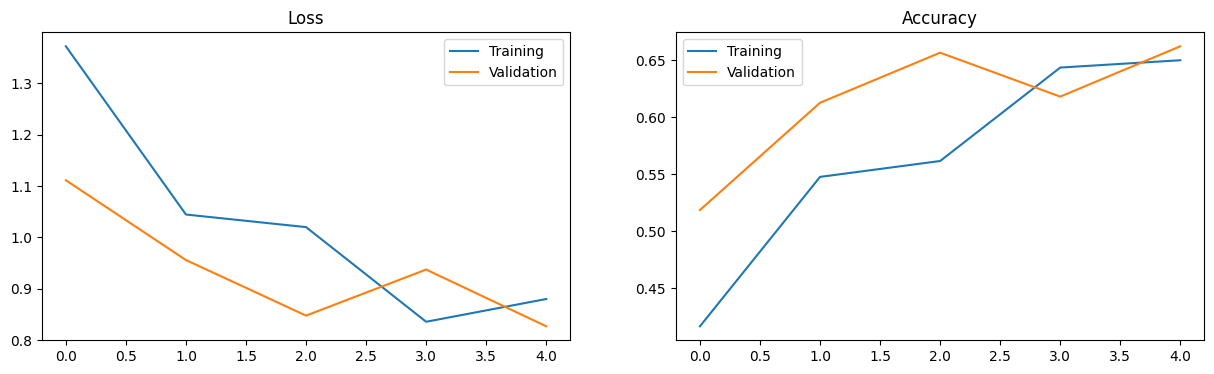

In [50]:
plt.figure(figsize = (15, 4))

plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(trainer.history['train_loss'], label = 'Training')
plt.plot(trainer.history['val_loss'], label = 'Validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(trainer.history['train_acc'], label = 'Training')
plt.plot(trainer.history['val_acc'], label = 'Validation')
plt.legend()

In [51]:
preds, true = [], []

with torch.no_grad():
    for x, y in tqdm(val_loader):
        pred = torch.argmax(trainer.model(x.to(device)), axis = 1).detach().cpu().numpy()
        preds.extend(pred)
        true.extend(y)
        
len(preds), len(true)

100%|██████████| 20/20 [00:16<00:00,  1.21it/s]


(633, 633)

Text(0.5, 1.0, 'Confusion Matrix')

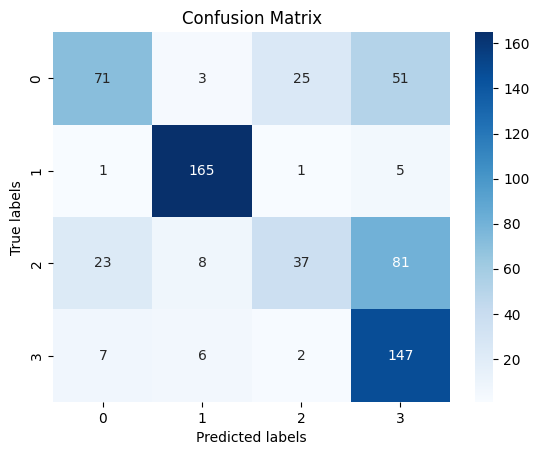

In [52]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true, preds)
sea.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

In [53]:
from sklearn.metrics import classification_report

print(classification_report(true, preds, target_names = label2id.keys()))

                      precision    recall  f1-score   support

            cataract       0.70      0.47      0.56       150
diabetic_retinopathy       0.91      0.96      0.93       172
            glaucoma       0.57      0.25      0.35       149
              normal       0.52      0.91      0.66       162

            accuracy                           0.66       633
           macro avg       0.67      0.65      0.63       633
        weighted avg       0.68      0.66      0.64       633

